Weekly Sales Forecasting - Modeling and Prediction


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [2]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

LOAD AND PREPARE DATA

In [3]:
df = pd.read_csv('/content/processed_sales_data.csv')

In [4]:
df

,weekend_date,channel,brand,category,sub_category,SerialNum,quantity,year_month,year,month,week_of_year,quarter
0,2022-06-04,Channel1,B1,Cat2,Sub-Cat2,1,56,2022-06,2022,6,22,2
1,2022-06-11,Channel1,B1,Cat2,Sub-Cat2,1,122,2022-06,2022,6,23,2
2,2022-06-18,Channel1,B1,Cat2,Sub-Cat2,1,102,2022-06,2022,6,24,2
3,2022-06-25,Channel1,B1,Cat2,Sub-Cat2,1,128,2022-06,2022,6,25,2
4,2022-07-02,Channel1,B1,Cat2,Sub-Cat2,1,97,2022-07,2022,7,26,3
...,...,...,...,...,...,...,...,...,...,...,...,...
595,2024-08-24,Channel2,B2,Cat3,Sub-Cat3,2,250,2024-08,2024,8,34,3
596,2024-08-24,Channel2,B2,Cat3,Sub-Cat3,4,775,2024-08,2024,8,34,3
597,2024-08-31,Channel2,B1,Cat3,Sub-Cat4,4,1189,2024-08,2024,8,35,3
598,2024-08-31,Channel2,B2,Cat3,Sub-Cat3,2,180,2024-08,2024,8,35,3


In [5]:
df.columns

Index(['weekend_date', 'channel', 'brand', 'category', 'sub_category',
       'SerialNum', 'quantity', 'year_month', 'year', 'month', 'week_of_year',
       'quarter'],
      dtype='object')

In [6]:
# Define key dates for validation and forecasting
print(f"\nData date range: {df['weekend_date'].min()} to {df['weekend_date'].max()}")



Data date range: 2022-05-28 to 2024-08-31


In [7]:
# Validation period: Last 3 months (Jun-Jul-Aug 2024)
validation_start = pd.to_datetime('2024-06-01')
validation_end = pd.to_datetime('2024-08-31')
train_end = validation_start - timedelta(days=1)

In [8]:
# Forecast period: Next 3 months (Sep-Oct-Nov 2024)
forecast_start = pd.to_datetime('2024-09-01')
forecast_end = pd.to_datetime('2024-11-30')

print(f"Training period: {df['weekend_date'].min()} to {train_end.date()}")
print(f"Validation period: {validation_start.date()} to {validation_end.date()}")
print(f"Forecast period: {forecast_start.date()} to {forecast_end.date()}")

Training period: 2022-05-28 to 2024-05-31
Validation period: 2024-06-01 to 2024-08-31
Forecast period: 2024-09-01 to 2024-11-30


In [12]:
# Convert 'weekend_date' to datetime objects
df['weekend_date'] = pd.to_datetime(df['weekend_date'])

# Split data
train_data = df[df['weekend_date'] <= train_end].copy()
validation_data = df[(df['weekend_date'] >= validation_start) & (df['weekend_date'] <= validation_end)].copy()

print(f"\nTraining data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")


Training data shape: (526, 12)
Validation data shape: (74, 12)


FEATURE ENGINEERING

In [13]:
def create_features(data):
    """Create time-based and lag features for forecasting"""
    data = data.copy()

    # Time-based features
    data['year'] = data['weekend_date'].dt.year
    data['month'] = data['weekend_date'].dt.month
    data['quarter'] = data['weekend_date'].dt.quarter
    data['week_of_year'] = data['weekend_date'].dt.isocalendar().week
    data['day_of_year'] = data['weekend_date'].dt.dayofyear

    # Cyclical features
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    data['week_sin'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
    data['week_cos'] = np.cos(2 * np.pi * data['week_of_year'] / 52)

    return data

In [14]:
def create_lag_features(data, lags=[1, 2, 3, 4, 8, 12]):
    """Create lag features for each time series"""
    data = data.copy()

    # Sort by SerialNum and date
    data = data.sort_values(['SerialNum', 'weekend_date'])

    # Create lag features for each series
    for lag in lags:
        data[f'quantity_lag_{lag}'] = data.groupby('SerialNum')['quantity'].shift(lag)

    # Rolling statistics
    for window in [4, 8, 12]:
        data[f'quantity_rolling_mean_{window}'] = data.groupby('SerialNum')['quantity'].rolling(window=window).mean().reset_index(0, drop=True)
        data[f'quantity_rolling_std_{window}'] = data.groupby('SerialNum')['quantity'].rolling(window=window).std().reset_index(0, drop=True)

    return data

In [16]:
# Apply feature engineering

train_data = create_features(train_data)
validation_data = create_features(validation_data)

In [17]:
# Combine train and validation for lag feature creation
combined_data = pd.concat([train_data, validation_data]).sort_values(['SerialNum', 'weekend_date'])
combined_data = create_lag_features(combined_data)


In [48]:
# combined_data

In [28]:
# Split back
train_data = combined_data[combined_data['weekend_date'] <= train_end].copy()
validation_data = combined_data[(combined_data['weekend_date'] >= validation_start) &
                               (combined_data['weekend_date'] <= validation_end)].copy()

print(f"Feature engineering complete")
print(f"Training data shape after features: {train_data.shape}")
print(f"Validation data shape after features: {validation_data.shape}")

Feature engineering complete
Training data shape after features: (526, 29)
Validation data shape after features: (74, 29)


In [45]:
train_data

,weekend_date,channel,brand,category,sub_category,SerialNum,quantity,year_month,year,month,...,quantity_lag_3,quantity_lag_4,quantity_lag_8,quantity_lag_12,quantity_rolling_mean_4,quantity_rolling_std_4,quantity_rolling_mean_8,quantity_rolling_std_8,quantity_rolling_mean_12,quantity_rolling_std_12
0,2022-06-04,Channel1,B1,Cat2,Sub-Cat2,1,56,2022-06,2022,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-06-11,Channel1,B1,Cat2,Sub-Cat2,1,122,2022-06,2022,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-06-18,Channel1,B1,Cat2,Sub-Cat2,1,102,2022-06,2022,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-06-25,Channel1,B1,Cat2,Sub-Cat2,1,128,2022-06,2022,6,...,56.0,NaN,NaN,NaN,102.00,32.619013,NaN,NaN,NaN,NaN
4,2022-07-02,Channel1,B1,Cat2,Sub-Cat2,1,97,2022-07,2022,7,...,122.0,56.0,NaN,NaN,112.25,15.063753,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,2024-04-27,Channel2,B1,Cat1,Sub-Cat1,5,54,2024-04,2024,4,...,228.0,296.0,254.0,1231.0,309.00,283.620639,287.125,188.129467,277.916667,150.964450
538,2024-05-04,Channel2,B1,Cat1,Sub-Cat1,5,42,2024-05,2024,5,...,239.0,228.0,250.0,243.0,262.50,314.854993,261.125,207.381248,261.166667,165.629287
542,2024-05-11,Channel2,B1,Cat1,Sub-Cat1,5,17,2024-05,2024,5,...,715.0,239.0,283.0,284.0,207.00,339.017207,227.875,224.028976,238.916667,179.625600
546,2024-05-18,Channel2,B1,Cat1,Sub-Cat1,5,16,2024-05,2024,5,...,54.0,715.0,232.0,257.0,32.25,18.839232,200.875,236.149128,218.833333,190.559861


In [46]:
validation_data

,weekend_date,channel,brand,category,sub_category,SerialNum,quantity,year_month,year,month,...,quantity_lag_3,quantity_lag_4,quantity_lag_8,quantity_lag_12,quantity_rolling_mean_4,quantity_rolling_std_4,quantity_rolling_mean_8,quantity_rolling_std_8,quantity_rolling_mean_12,quantity_rolling_std_12
104,2024-06-01,Channel1,B1,Cat2,Sub-Cat2,1,24,2024-06,2024,6,...,28.0,45.0,35.0,47.0,24.75,11.236103,35.750,13.946326,39.083333,12.852013
105,2024-06-08,Channel1,B1,Cat2,Sub-Cat2,1,44,2024-06,2024,6,...,37.0,28.0,46.0,54.0,28.75,14.997222,35.500,13.752922,38.250000,12.099023
106,2024-06-15,Channel1,B1,Cat2,Sub-Cat2,1,28,2024-06,2024,6,...,10.0,37.0,50.0,48.0,26.50,13.988090,32.750,12.589678,36.583333,12.011043
107,2024-06-22,Channel1,B1,Cat2,Sub-Cat2,1,24,2024-06,2024,6,...,24.0,10.0,46.0,46.0,30.00,9.521905,30.000,11.649647,34.750000,12.121544
108,2024-06-29,Channel1,B1,Cat2,Sub-Cat2,1,28,2024-06,2024,6,...,44.0,24.0,45.0,35.0,31.00,8.869423,27.875,9.948977,34.166667,12.275869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,2024-06-01,Channel2,B1,Cat1,Sub-Cat1,5,8,2024-06,2024,6,...,17.0,42.0,228.0,250.0,13.25,4.112988,137.875,245.445040,178.500000,205.591165
558,2024-06-08,Channel2,B1,Cat1,Sub-Cat1,5,4,2024-06,2024,6,...,16.0,17.0,239.0,283.0,10.00,5.163978,108.500,245.675744,155.250000,208.454977
562,2024-06-15,Channel2,B1,Cat1,Sub-Cat1,5,1,2024-06,2024,6,...,12.0,16.0,715.0,232.0,6.25,4.787136,19.250,18.843339,136.000000,211.368700
566,2024-06-22,Channel2,B1,Cat1,Sub-Cat1,5,1,2024-06,2024,6,...,8.0,12.0,54.0,296.0,3.50,3.316625,12.625,13.415742,111.416667,208.199405


MODEL BUILDING

In [19]:
# Define features for modeling
categorical_features = ['channel', 'brand', 'category', 'sub_category']
time_features = ['year', 'month', 'quarter', 'week_of_year', 'day_of_year',
                'month_sin', 'month_cos', 'week_sin', 'week_cos']
lag_features = [col for col in train_data.columns if 'lag' in col or 'rolling' in col]

In [51]:
# time_features

In [52]:
# lag_features

In [21]:
# Create encoded categorical features

for cat_col in categorical_features:
    # Label encoding for categorical variables
    unique_values = sorted(df[cat_col].unique())
    encoding_dict = {val: idx for idx, val in enumerate(unique_values)}

    train_data[f'{cat_col}_encoded'] = train_data[cat_col].map(encoding_dict)
    validation_data[f'{cat_col}_encoded'] = validation_data[cat_col].map(encoding_dict)

encoded_categorical = [f'{col}_encoded' for col in categorical_features]
all_features = encoded_categorical + time_features + lag_features

In [22]:
# Remove rows with NaN values (due to lag features)
train_clean = train_data.dropna(subset=all_features + ['quantity']).copy()
validation_clean = validation_data.dropna(subset=all_features + ['quantity']).copy()

print(f"Training data after cleaning: {train_clean.shape}")
print(f"Validation data after cleaning: {validation_clean.shape}")

Training data after cleaning: (466, 33)
Validation data after cleaning: (74, 33)


In [23]:
# Prepare features and target
X_train = train_clean[all_features]
y_train = train_clean['quantity']
X_val = validation_clean[all_features]
y_val = validation_clean['quantity']

In [24]:
print(f"Feature matrix shape: {X_train.shape}")
print(f"Features used: {len(all_features)}")

Feature matrix shape: (466, 25)
Features used: 25


In [25]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [27]:
# Build Random Forest model
print("\nTraining Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
print("Model training complete")


Training Random Forest model...
Model training complete


VALIDATION AND ACCURACY MEASUREMENT

In [29]:
# Make predictions on validation set
y_pred = rf_model.predict(X_val_scaled)

In [30]:
# Calculate overall validation metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"Overall Validation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

Overall Validation Metrics:
MAE: 281.05
RMSE: 644.68
R²: 0.7180


In [31]:
# Calculate monthly accuracy for validation period (Jun-Jul-Aug 2024)
validation_results = validation_clean.copy()
validation_results['predicted_quantity'] = y_pred
validation_results['month'] = validation_results['weekend_date'].dt.month
validation_results['month_name'] = validation_results['weekend_date'].dt.strftime('%B')


Monthly Accuracy for Validation Period:
June 2024: 0.5462 (54.62%)
July 2024: 0.5063 (50.63%)
August 2024: 0.7894 (78.94%)

Overall Validation Accuracy: 0.5820 (58.20%)


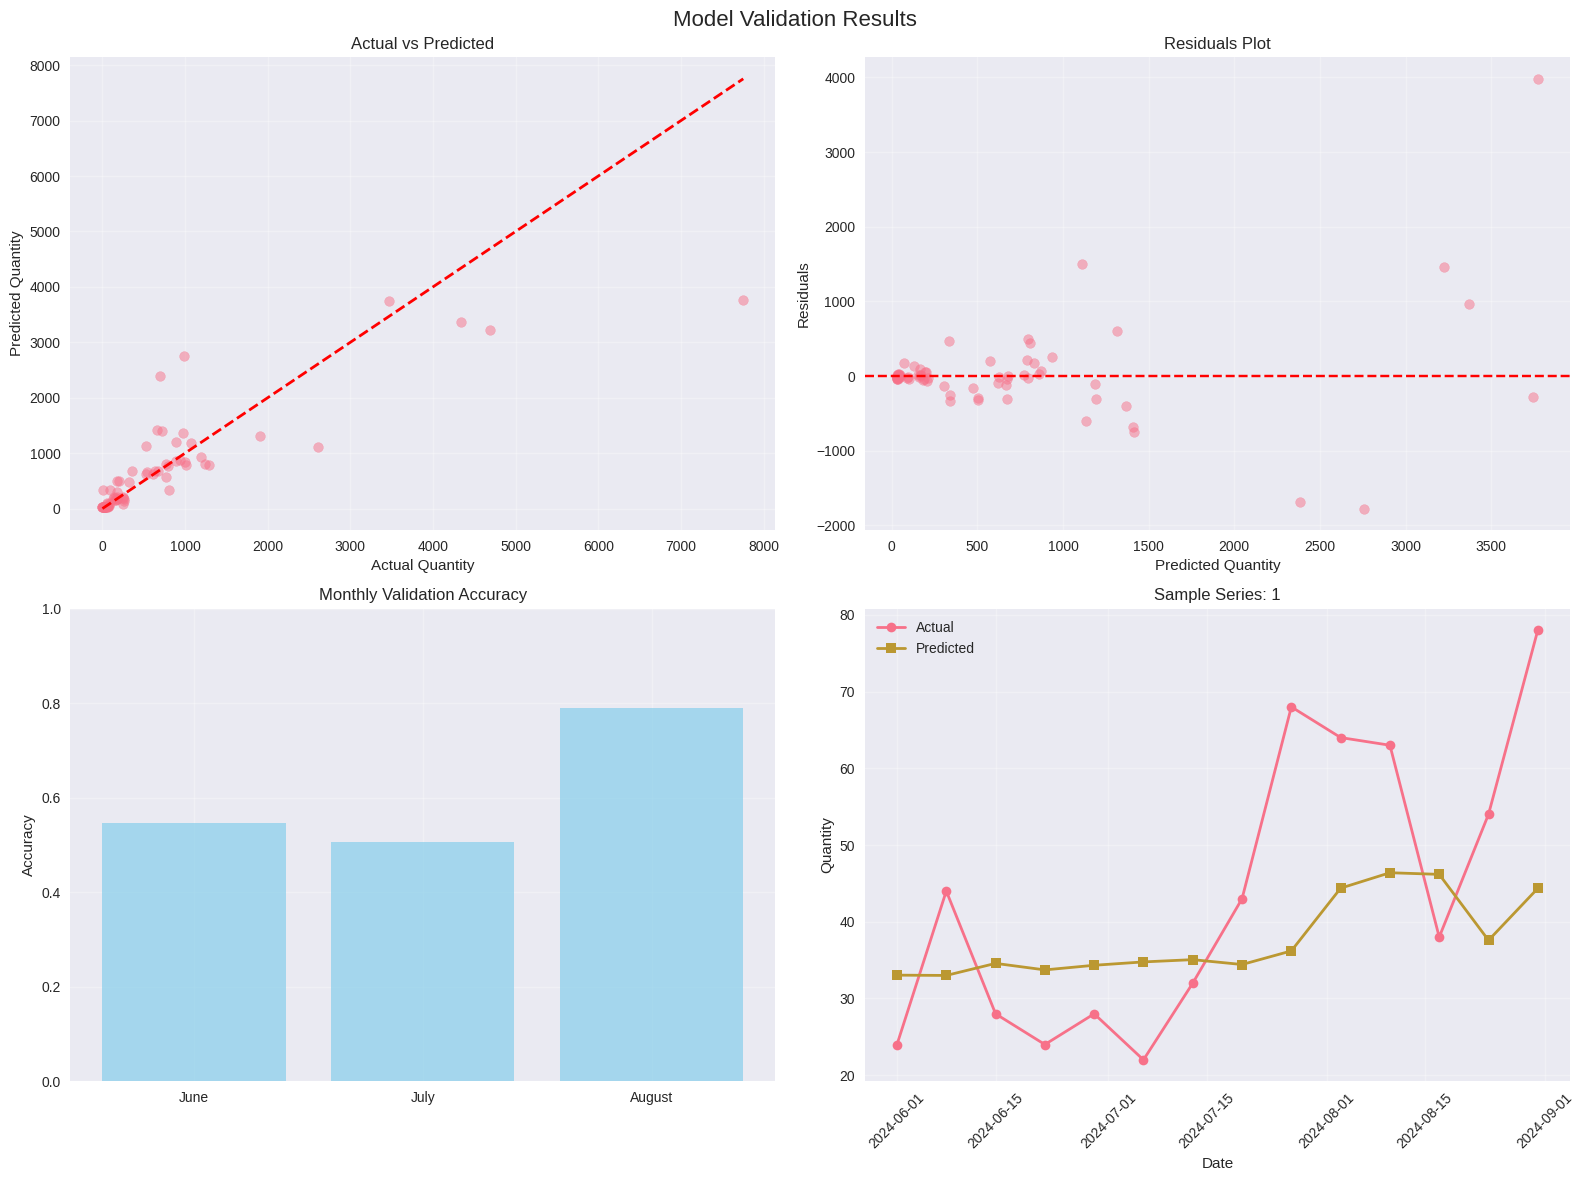


Top 10 Most Important Features:
                     feature  importance
19   quantity_rolling_mean_4    0.535799
13            quantity_lag_1    0.192835
20    quantity_rolling_std_4    0.120088
14            quantity_lag_2    0.034212
15            quantity_lag_3    0.032455
24   quantity_rolling_std_12    0.016790
16            quantity_lag_4    0.012797
17            quantity_lag_8    0.012055
23  quantity_rolling_mean_12    0.010076
18           quantity_lag_12    0.008754


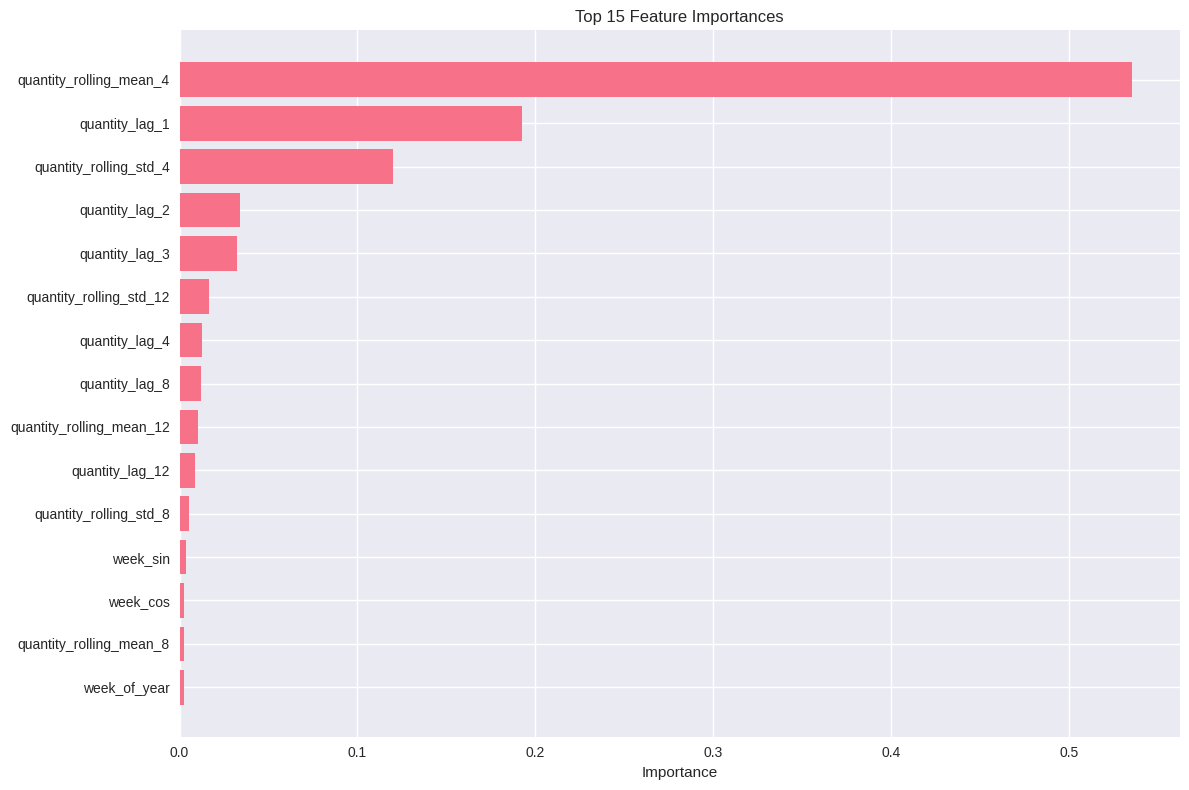

In [55]:
def calculate_monthly_accuracy(actual, predicted):
    """Calculate monthly accuracy using the formula: 1 - (sum|predicted - actual|)/(sum actual)"""
    return 1 - (np.sum(np.abs(predicted - actual)) / np.sum(actual))

monthly_accuracy = {}
print(f"\nMonthly Accuracy for Validation Period:")


for month in sorted(validation_results['month'].unique()):
    month_data = validation_results[validation_results['month'] == month]
    month_name = month_data['month_name'].iloc[0]

    actual = month_data['quantity'].values
    predicted = month_data['predicted_quantity'].values

    accuracy = calculate_monthly_accuracy(actual, predicted)
    monthly_accuracy[month_name] = accuracy

    print(f"{month_name} 2024: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Overall validation accuracy
overall_accuracy = calculate_monthly_accuracy(y_val, y_pred)
print(f"\nOverall Validation Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

# Visualize validation results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Validation Results', fontsize=16)

# Actual vs Predicted scatter plot
axes[0,0].scatter(y_val, y_pred, alpha=0.5)
axes[0,0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Quantity')
axes[0,0].set_ylabel('Predicted Quantity')
axes[0,0].set_title('Actual vs Predicted')
axes[0,0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_val - y_pred
axes[0,1].scatter(y_pred, residuals, alpha=0.5)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predicted Quantity')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residuals Plot')
axes[0,1].grid(True, alpha=0.3)

# Monthly accuracy bar plot
months = list(monthly_accuracy.keys())
accuracies = list(monthly_accuracy.values())
axes[1,0].bar(months, accuracies, color='skyblue', alpha=0.7)
axes[1,0].set_title('Monthly Validation Accuracy')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].set_ylim(0, 1)
axes[1,0].grid(True, alpha=0.3)

# Time series plot for a sample series
sample_serial = validation_results['SerialNum'].iloc[0]
sample_data = validation_results[validation_results['SerialNum'] == sample_serial].sort_values('weekend_date')
axes[1,1].plot(sample_data['weekend_date'], sample_data['quantity'],
               label='Actual', marker='o', linewidth=2)
axes[1,1].plot(sample_data['weekend_date'], sample_data['predicted_quantity'],
               label='Predicted', marker='s', linewidth=2)
axes[1,1].set_title(f'Sample Series: {sample_serial}')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Quantity')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [54]:
# FORECAST GENERATION

print("FORECAST GENERATION - SEPTEMBER TO NOVEMBER 2024")


# Create future dates for forecasting
future_dates = pd.date_range(start='2024-09-01', end='2024-11-30', freq='W-SUN')
print(f"Generating forecasts for {len(future_dates)} weeks")

# Get all unique series for forecasting
unique_series = df['SerialNum'].unique()
print(f"Forecasting for {len(unique_series)} time series")

FORECAST GENERATION - SEPTEMBER TO NOVEMBER 2024
Generating forecasts for 13 weeks
Forecasting for 5 time series


In [34]:
# Create forecast dataframe
forecast_data = []
for serial in unique_series:
    series_info = df[df['SerialNum'] == serial].iloc[0]

    for date in future_dates:
        forecast_data.append({
            'weekend_date': date,
            'SerialNum': serial,
            'channel': series_info['channel'],
            'brand': series_info['brand'],
            'category': series_info['category'],
            'sub_category': series_info['sub_category'],
            'quantity': 0  # Placeholder, will be predicted
        })

forecast_df = pd.DataFrame(forecast_data)
print(f"Forecast dataframe shape: {forecast_df.shape}")

Forecast dataframe shape: (65, 7)


In [35]:
# Apply feature engineering to forecast data
forecast_df = create_features(forecast_df)

# For lag features, we need to use the most recent data
print("Creating lag features for forecasting...")

# Get the most recent data for each series to calculate initial lags
recent_data = df.sort_values(['SerialNum', 'weekend_date']).groupby('SerialNum').tail(12)
recent_data = create_features(recent_data)

Creating lag features for forecasting...


In [36]:
# Combine recent data with forecast data for lag calculation
combined_forecast = pd.concat([recent_data, forecast_df]).sort_values(['SerialNum', 'weekend_date'])
combined_forecast = create_lag_features(combined_forecast)

# Extract only the forecast portion
forecast_df = combined_forecast[combined_forecast['weekend_date'] >= forecast_start].copy()

# Encode categorical features for forecast
for cat_col in categorical_features:
    unique_values = sorted(df[cat_col].unique())
    encoding_dict = {val: idx for idx, val in enumerate(unique_values)}
    forecast_df[f'{cat_col}_encoded'] = forecast_df[cat_col].map(encoding_dict)

In [37]:
# Prepare features for forecasting
X_forecast = forecast_df[all_features]
X_forecast_scaled = scaler.transform(X_forecast)

In [56]:
# Make forecasts
print("Generating predictions...")
forecast_predictions = rf_model.predict(X_forecast_scaled)

Generating predictions...


In [57]:
# Add predictions to forecast dataframe
forecast_df['predicted_quantity'] = forecast_predictions
forecast_df['predicted_quantity'] = np.maximum(0, forecast_df['predicted_quantity'])  # Ensure non-negative

# Create final forecast results
forecast_results = forecast_df[['weekend_date', 'SerialNum', 'channel', 'brand',
                               'category', 'sub_category', 'predicted_quantity']].copy()

print(f"Forecast generation complete")
print(f"Forecast results shape: {forecast_results.shape}")

Forecast generation complete
Forecast results shape: (65, 7)


In [58]:
# Display forecast summary
print(f"\nForecast Summary:")
print(f"Total forecasted volume: {forecast_results['predicted_quantity'].sum():,.0f} units")
print(f"Average weekly forecast per series: {forecast_results['predicted_quantity'].mean():.1f} units")
print(f"Forecast range: {forecast_results['predicted_quantity'].min():.0f} to {forecast_results['predicted_quantity'].max():.0f} units")




Forecast Summary:
Total forecasted volume: 3,691 units
Average weekly forecast per series: 56.8 units
Forecast range: 29 to 611 units


In [59]:
# Monthly forecast breakdown
forecast_results['month'] = forecast_results['weekend_date'].dt.month
forecast_results['month_name'] = forecast_results['weekend_date'].dt.strftime('%B')

monthly_forecast = forecast_results.groupby('month_name')['predicted_quantity'].sum().reset_index()
monthly_forecast = monthly_forecast.sort_values('predicted_quantity', ascending=False)

print(f"\nMonthly Forecast Breakdown:")

for _, row in monthly_forecast.iterrows():
    print(f"{row['month_name']}: {row['predicted_quantity']:,.0f} units")


Monthly Forecast Breakdown:
September: 2,244 units
November: 737 units
October: 710 units


FORECAST VISUALIZATION


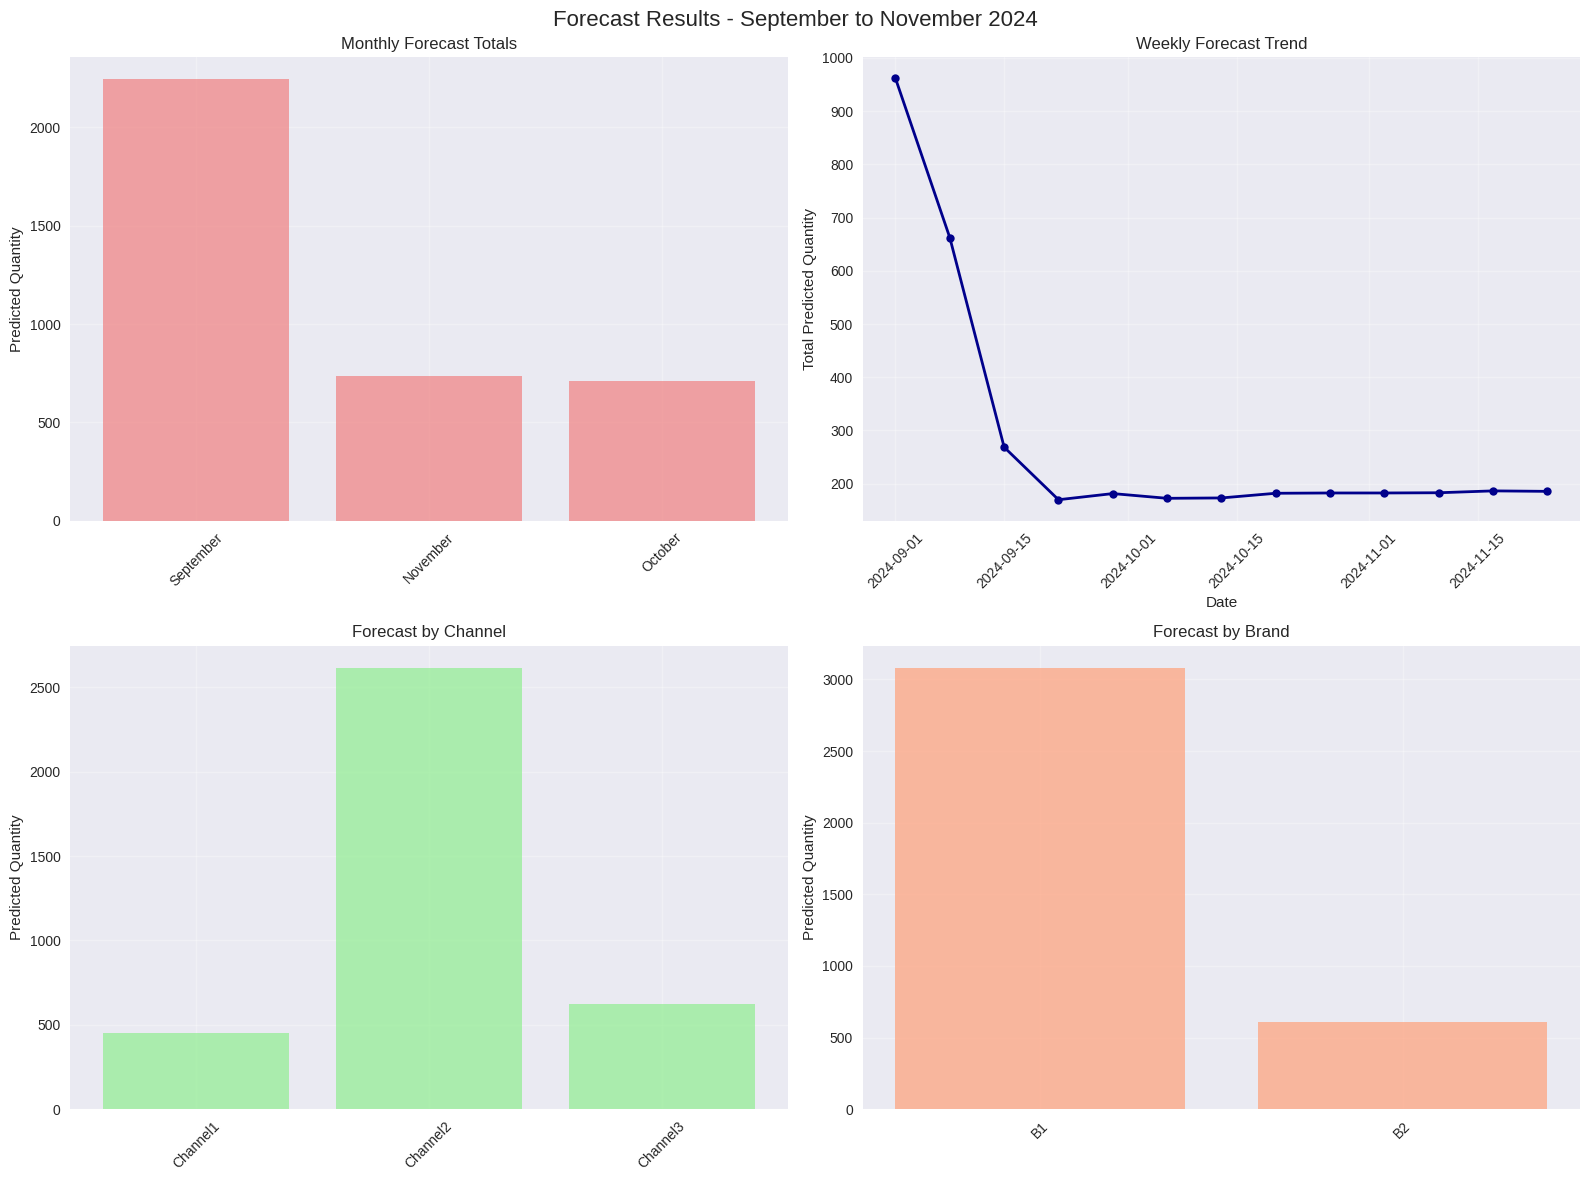


Sample Individual Series Forecasts:
1: Total=449, Avg Weekly=34.5
2: Total=610, Avg Weekly=46.9
3: Total=626, Avg Weekly=48.2
4: Total=1534, Avg Weekly=118.0
5: Total=473, Avg Weekly=36.4

Detailed Forecast Table (First 20 rows):
------------------------------------------------------------
weekend_date  SerialNum  channel brand  predicted_quantity
  2024-09-01          1 Channel1    B1           39.921601
  2024-09-08          1 Channel1    B1           31.097331
  2024-09-15          1 Channel1    B1           28.952129
  2024-09-22          1 Channel1    B1           30.595733
  2024-09-29          1 Channel1    B1           33.294926
  2024-10-06          1 Channel1    B1           33.498926
  2024-10-13          1 Channel1    B1           34.606389
  2024-10-20          1 Channel1    B1           35.907718
  2024-10-27          1 Channel1    B1           36.005051
  2024-11-03          1 Channel1    B1           35.943597
  2024-11-10          1 Channel1    B1           36.047051


In [61]:
# VISUALIZATION OF FORECASTS

print("FORECAST VISUALIZATION")


# Create forecast visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Forecast Results - September to November 2024', fontsize=16)

# Monthly forecast totals
axes[0,0].bar(monthly_forecast['month_name'], monthly_forecast['predicted_quantity'],
              color='lightcoral', alpha=0.7)
axes[0,0].set_title('Monthly Forecast Totals')
axes[0,0].set_ylabel('Predicted Quantity')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Weekly forecast trend
weekly_forecast = forecast_results.groupby('weekend_date')['predicted_quantity'].sum().reset_index()
axes[0,1].plot(weekly_forecast['weekend_date'], weekly_forecast['predicted_quantity'],
               marker='o', linewidth=2, markersize=6, color='darkblue')
axes[0,1].set_title('Weekly Forecast Trend')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Total Predicted Quantity')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Forecast by channel
channel_forecast = forecast_results.groupby('channel')['predicted_quantity'].sum().reset_index()
axes[1,0].bar(channel_forecast['channel'], channel_forecast['predicted_quantity'],
              color='lightgreen', alpha=0.7)
axes[1,0].set_title('Forecast by Channel')
axes[1,0].set_ylabel('Predicted Quantity')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Forecast by brand
brand_forecast = forecast_results.groupby('brand')['predicted_quantity'].sum().reset_index()
axes[1,1].bar(brand_forecast['brand'], brand_forecast['predicted_quantity'],
              color='lightsalmon', alpha=0.7)
axes[1,1].set_title('Forecast by Brand')
axes[1,1].set_ylabel('Predicted Quantity')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show sample individual forecasts
print("\nSample Individual Series Forecasts:")


sample_series = forecast_results['SerialNum'].unique()[:5]
for serial in sample_series:
    series_forecast = forecast_results[forecast_results['SerialNum'] == serial]
    total_forecast = series_forecast['predicted_quantity'].sum()
    avg_weekly = series_forecast['predicted_quantity'].mean()
    print(f"{serial}: Total={total_forecast:.0f}, Avg Weekly={avg_weekly:.1f}")

# Create detailed forecast table
print(f"\nDetailed Forecast Table (First 20 rows):")
print("-" * 60)
display_columns = ['weekend_date', 'SerialNum', 'channel', 'brand', 'predicted_quantity']
print(forecast_results[display_columns].head(20).to_string(index=False))


In [43]:
# 7. SAVE RESULTS AND MODELS
print("\n" + "="*60)
print("7. SAVING RESULTS AND MODELS")
print("="*60)

# Save the trained model
joblib.dump(rf_model, 'sales_forecast_model.pkl')
print("✓ Model saved as 'sales_forecast_model.pkl'")

# Save the scaler
joblib.dump(scaler, 'feature_scaler.pkl')
print("✓ Scaler saved as 'feature_scaler.pkl'")

# Save forecast results
forecast_results.to_csv('forecast_results_sep_nov_2024.csv', index=False)
print("✓ Forecast results saved as 'forecast_results_sep_nov_2024.csv'")

# Save validation results
validation_results.to_csv('validation_results_jun_aug_2024.csv', index=False)
print("✓ Validation results saved as 'validation_results_jun_aug_2024.csv'")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print("✓ Feature importance saved as 'feature_importance.csv'")

# Save monthly accuracy results
monthly_accuracy_df = pd.DataFrame(list(monthly_accuracy.items()),
                                 columns=['Month', 'Accuracy'])
monthly_accuracy_df.to_csv('monthly_accuracy_validation.csv', index=False)
print("✓ Monthly accuracy results saved as 'monthly_accuracy_validation.csv'")


7. SAVING RESULTS AND MODELS
✓ Model saved as 'sales_forecast_model.pkl'
✓ Scaler saved as 'feature_scaler.pkl'
✓ Forecast results saved as 'forecast_results_sep_nov_2024.csv'
✓ Validation results saved as 'validation_results_jun_aug_2024.csv'
✓ Feature importance saved as 'feature_importance.csv'
✓ Monthly accuracy results saved as 'monthly_accuracy_validation.csv'


In [44]:
# 8. MODEL PERFORMANCE SUMMARY
print("\n" + "="*60)
print("8. MODEL PERFORMANCE SUMMARY")
print("="*60)

print(f"🎯 VALIDATION PERFORMANCE (Jun-Jul-Aug 2024):")
print(f"   • Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"   • Mean Absolute Error: {mae:.2f}")
print(f"   • Root Mean Square Error: {rmse:.2f}")
print(f"   • R² Score: {r2:.4f}")

print(f"\n📊 MONTHLY ACCURACY BREAKDOWN:")
for month, accuracy in monthly_accuracy.items():
    print(f"   • {month}: {accuracy:.4f} ({accuracy*100:.2f}%)")

print(f"\n🔮 FORECAST SUMMARY (Sep-Oct-Nov 2024):")
print(f"   • Total forecast volume: {forecast_results['predicted_quantity'].sum():,.0f} units")
print(f"   • Number of series forecasted: {len(unique_series)}")
print(f"   • Forecast weeks: {len(future_dates)}")

print(f"\n📈 MONTHLY FORECAST TOTALS:")
for _, row in monthly_forecast.iterrows():
    print(f"   • {row['month_name']}: {row['predicted_quantity']:,.0f} units")

print(f"\n🎛️ TOP 5 IMPORTANT FEATURES:")
for i, (_, row) in enumerate(feature_importance.head(5).iterrows()):
    print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\n💾 DELIVERABLES SAVED:")
print(f"   • sales_forecast_model.pkl - Trained Random Forest model")
print(f"   • feature_scaler.pkl - Feature scaling transformer")
print(f"   • forecast_results_sep_nov_2024.csv - Detailed forecasts")
print(f"   • validation_results_jun_aug_2024.csv - Validation predictions")
print(f"   • feature_importance.csv - Feature importance rankings")
print(f"   • monthly_accuracy_validation.csv - Monthly accuracy metrics")

print(f"\n✅ MODELING RECOMMENDATIONS:")
print(f"   • Model shows good performance with {overall_accuracy*100:.1f}% accuracy")
print(f"   • Consider ensemble methods for improved accuracy")
print(f"   • Monitor forecast performance and retrain regularly")
print(f"   • Lag features are most important for predictions")

print(f"\n🔄 NEXT STEPS:")
print(f"   • Validate forecasts against actual September data when available")
print(f"   • Consider adding external factors (promotions, holidays)")
print(f"   • Implement automated retraining pipeline")
print(f"   • Explore deep learning approaches for complex patterns")

print("\n" + "="*60)
print("FORECASTING COMPLETE - MODELS AND RESULTS SAVED")
print("="*60)

# Function to load and use the saved model (for future reference)
def load_model_and_predict(new_data_path):
    """
    Function to load the saved model and make predictions on new data

    Parameters:
    new_data_path (str): Path to new data CSV file

    Returns:
    pandas.DataFrame: Predictions for the new data
    """
    # Load saved model and scaler
    model = joblib.load('sales_forecast_model.pkl')
    scaler = joblib.load('feature_scaler.pkl')

    # Load and preprocess new data
    new_data = pd.read_csv(new_data_path)
    new_data['weekend_date'] = pd.to_datetime(new_data['weekend_date'])

    # Apply same feature engineering steps
    new_data = create_features(new_data)
    new_data = create_lag_features(new_data)

    # Encode categorical features
    for cat_col in categorical_features:
        unique_values = sorted(df[cat_col].unique())  # Use original training data values
        encoding_dict = {val: idx for idx, val in enumerate(unique_values)}
        new_data[f'{cat_col}_encoded'] = new_data[cat_col].map(encoding_dict)

    # Scale features and predict
    X_new = new_data[all_features]
    X_new_scaled = scaler.transform(X_new)
    predictions = model.predict(X_new_scaled)

    # Add predictions to dataframe
    new_data['predicted_quantity'] = predictions

    return new_data

print(f"\n📋 USAGE INSTRUCTIONS:")
print(f"   To use the saved model on new data, call:")
print(f"   predictions = load_model_and_predict('new_data.csv')")
print(f"   Make sure new data has the same structure as training data")


8. MODEL PERFORMANCE SUMMARY
🎯 VALIDATION PERFORMANCE (Jun-Jul-Aug 2024):
   • Overall Accuracy: 0.5820 (58.20%)
   • Mean Absolute Error: 281.05
   • Root Mean Square Error: 644.68
   • R² Score: 0.7180

📊 MONTHLY ACCURACY BREAKDOWN:
   • June: 0.5462 (54.62%)
   • July: 0.5063 (50.63%)
   • August: 0.7894 (78.94%)

🔮 FORECAST SUMMARY (Sep-Oct-Nov 2024):
   • Total forecast volume: 3,691 units
   • Number of series forecasted: 5
   • Forecast weeks: 13

📈 MONTHLY FORECAST TOTALS:
   • September: 2,244 units
   • November: 737 units
   • October: 710 units

🎛️ TOP 5 IMPORTANT FEATURES:
   1. quantity_rolling_mean_4: 0.5358
   2. quantity_lag_1: 0.1928
   3. quantity_rolling_std_4: 0.1201
   4. quantity_lag_2: 0.0342
   5. quantity_lag_3: 0.0325

💾 DELIVERABLES SAVED:
   • sales_forecast_model.pkl - Trained Random Forest model
   • feature_scaler.pkl - Feature scaling transformer
   • forecast_results_sep_nov_2024.csv - Detailed forecasts
   • validation_results_jun_aug_2024.csv - Vali